In [1]:
import numpy as np
import visa
import matplotlib.pyplot as plt
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
from lantz import ureg
import sounddevice as sd

In [2]:
class Generador(MessageBasedDriver):
#    def __init__(self,ID):
#        self.obj_visa=rm.open_resource(ID)
#        self.ID = ID
    set_query = MessageBasedDriver.write
    # Feats punciona como un property, pero ademas acepta otras opciones
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    # La idea es no usar sets and gets como metodos, sino definir propiedades
        
    frequency = mfeats.QuantityFeat('SOURce1:FREQuency:FIXed?','SOURce1:FREQuency:FIXed {}',units='Hz',limits=(0.0,1000000))
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.05,5))
        
    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

        
class Osciloscopio(MessageBasedDriver):

    set_query = MessageBasedDriver.write
    
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    timebase = mfeats.QuantityFeat('HORizontal:MAIN:SCALe?','HORizontal:MAIN:SCALe {}',units='s')
    vertical_scale = mfeats.QuantityFeat('CH1:SCA?','CH1:SCA {}',units='V')

    def vpp(self):
        osci.write('MEASUrement:IMMed:TYPE PK2pk')
        return float(osci.query('MEASUREMENT:IMMed:VALue?'))
        
  #  @Feat()
    def capturaPantalla(self):
 #       if self.parameters is None:
        YOFF_in_dl = float(self.query("WFMP:YOFF?"))
        YZERO_in_YUNits = float(self.query("WFMP:YZERO?"))
        YMUlt = float(self.query("WFMP:YMULT?"))
        print(YOFF_in_dl,YZERO_in_YUNits,YMUlt)
     #   self.parameters = (YOFF_in_dl,YZERO_in_YUNits,YMUlt)
      #  (YOFF_in_dl , YZERO_in_YUNits , YMUlt) = self.parameters
        curve_in_dl = np.array(self.query_binary_values('CURV?', datatype='b', is_big_endian=True))
        valores = ((curve_in_dl - YOFF_in_dl)*YMUlt)+YZERO_in_YUNits
        intervalo = float(osci.query('WFMPre:XINcr?'))
        tiempos = np.arange(len(valores))*intervalo
        return tiempos, valores

In [3]:
def sweepe(gener, osci, init_freq = 100, end_freq = 10100, cant_med = 100):
    with osci as osciloscopio, gener as generador:
        paso = np.floor(np.divide(end_freq - init_freq,cant_med))
        values = np.zeros(cant_med)
        freqs = np.add(np.multiply(np.arange(cant_med), paso), init_freq)
        for i,freq in enumerate(freqs):
            periodo = np.divide(1,freq)
            osciloscopio.timebase = 0.1*periodo*4*ureg.seconds 
        # Escribir Generador
            generador.frequency= freq*ureg.hertz
        # Esperamos a que se setee y lea bien
            time.sleep(1)
        # Consulta Osciloscopio
        #osci.obj_visa.write('MEASUrement:IMMed:TYPE PK2pk')
            values[i] = osciloscopio.vpp()#float(osci.obj_visa.query('MEASUREMENT:IMMed:VALue?'))
        return freqs, values

In [3]:
def sweepe_placa(gener, init_freq = 100, end_freq = 1100, cant_med = 100,prom_number=1):
    with gener as generador:
        paso = np.floor(np.divide(end_freq - init_freq,cant_med))
        amplitud = np.zeros(cant_med)
        offset = np.zeros(cant_med)
        freqs = np.add(np.multiply(np.arange(cant_med), paso), init_freq)
        for i,freq in enumerate(freqs):
            periodo = np.divide(1,freq)
            generador.frequency= freq*ureg.hertz
        # Esperamos a que se setee y lea bien
            time.sleep(1)
            numero_de_muestras = int(2* periodo * sd.default.samplerate)
            amplitud_prom = 0
            offset_prom = 0
            for n in range(prom_number):
            # Consulta Placa
                myrecording = sd.rec(numero_de_muestras,channels=2,blocking=True)
                medicion = np.asarray([i[0] for i in myrecording])
                maximo = np.max(medicion)
                minimo = np.min(medicion)
                amplitud_prom = amplitud_prom + maximo - minimo
                offset_prom = offset_prom + np.divide(maximo + minimo,2)
            amplitud[i] = np.divide(amplitud_prom,prom_number)
            offset[i] = np.divide(offset_prom,prom_number)
        return freqs, amplitud, offset

In [39]:
def sweepe_placa_ampl(gener, init_ampl = 0.05, end_ampl = 4, cant_med = 100,prom_number=1):
    with gener as generador:
        paso = (np.divide(end_ampl - init_ampl,cant_med))
        amplitud = np.zeros(cant_med)
        offset = np.zeros(cant_med)
        ampl = np.add(np.multiply(np.arange(cant_med), paso), init_ampl)
        for i,freq in enumerate(ampl):
            periodo = np.divide(1,1000)
            generador.amplitude= freq*ureg.volts
        # Esperamos a que se setee y lea bien
            time.sleep(1)
            numero_de_muestras = int(2* periodo * sd.default.samplerate)
            amplitud_prom = 0
            offset_prom = 0
            for n in range(prom_number):
            # Consulta Placa
                myrecording = sd.rec(numero_de_muestras,channels=2,blocking=True)
                medicion = np.asarray([i[0] for i in myrecording])
                maximo = np.max(medicion)
                minimo = np.min(medicion)
                amplitud_prom = amplitud_prom + maximo - minimo
                offset_prom = offset_prom + np.divide(maximo + minimo,2)
            amplitud[i] = np.divide(amplitud_prom,prom_number)
            offset[i] = np.divide(offset_prom,prom_number)
        return ampl, amplitud, offset

In [4]:
rm = visa.ResourceManager()
ID=rm.list_resources()
genf = Generador(ID[0])
#osci = Osciloscopio(ID[1])

In [14]:
with osci as osciloscopio, genf as generador:   
    osciloscopio.vertical_scale = 1.0* ureg.volts
   # generador.amplitude = 0.05 * ureg.volts
    print(generador.idn)
    generador.frequency = 100* ureg.hertz
    print(generador.frequency)
    print(osciloscopio.timebase)
    osciloscopio.timebase = 0.001*ureg.seconds
    #a,b=osciloscopio.capturaPantalla()

TEKTRONIX,AFG3021B,C034166,SCPI:99.0 FV:3.1.1

100.0 hertz
0.001 second


In [ ]:
frecuencias, valores = sweepe(genf, osci, cant_med = 20)
plt.plot(frecuencias,valores)
plt.show()

In [5]:
sd.query_devices()

  0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
> 1 Micrófono (Dispositivo de High , MME (2 in, 0 out)
  2 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
< 3 Auriculares (Dispositivo de Hig, MME (0 in, 2 out)
  4 Altavoces (Dispositivo de High , MME (0 in, 2 out)
  5 Headphones (Auricular de HD Audio), Windows WDM-KS (0 in, 2 out)
  6 Micrófono (Micrófono 2 de HD Audio), Windows WDM-KS (2 in, 0 out)
  7 Micrófono (Micrófono de HD Audio), Windows WDM-KS (2 in, 0 out)
  8 Speakers (Altavoz de HD Audio), Windows WDM-KS (0 in, 2 out)

In [6]:
sd.default.samplerate = 11025*4
print(sd.default.samplerate)

44100


In [7]:
def sinusoidal(freq, nperiods, sample_rate, points_per_period=100):
    tf = nperiods / freq
    t = np.linspace(0, tf, num=np.int(tf*sample_rate), endpoint=False)
    print(np.floor(tf*sample_rate))
    return t, np.sin(2*np.pi*t*sample_rate)
#myarray = np.sin(np.linspace(1,12,11025*400))
t, myarray=sinusoidal(440,1,4*11025)

100.0


In [52]:
def sinusoidal(ampl,freq, nperiods, sample_rate, points_per_period=100):
    t = np.linspace(0, 1, num=points_per_period, endpoint=False) * nperiods / freq
    #print(np.floor(tf*sample_rate))
    return t, ampl*np.sin(2*np.pi*t*freq)

t, myarray=sinusoidal(10,440,100,11025*4,400)

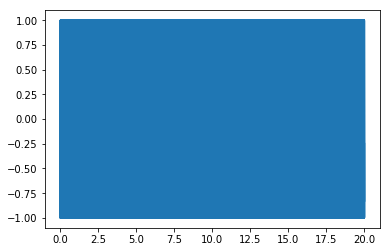

In [93]:
def sinusoidal(ampl, freq, duracion, sample_rate):
    N = np.int(duracion * sample_rate)
    t = np.linspace(0, 1, num=N, endpoint=False) * duracion * sample_rate
    #print(np.floor(tf*sample_rate))
    return t / sample_rate, ampl*np.sin(2*np.pi*t * freq/sample_rate)

t, myarray=sinusoidal(1,440,20,11025*1)
plt.plot(t, myarray)

In [94]:
sd.play(myarray)

In [67]:
duracion = np.divide(2,freq)
numero_de_muestras = int(duracion * sd.default.samplerate)
myrecording = sd.rec(numero_de_muestras,channels=2,blocking=True)
medicion=np.asarray([i[0] for i in myrecording])
maximo = np.max(medicion)
minimo = np.min(medicion)
amplitud = maximo -minimo
offset = np.divide(maximo + minimo,2)


0.6101074


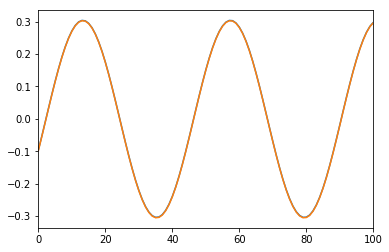

In [33]:
#plt.plot(myrecording)
myrecording = sd.rec(1*11025,channels=2,blocking=True)
a =myrecording.shape
mr1=myrecording.reshape((a[1],a[0]))
#plt.plot(mr1[0])
plt.plot(myrecording)
plt.xlim(0,100)
print(np.max(myrecording)-np.min(myrecording))


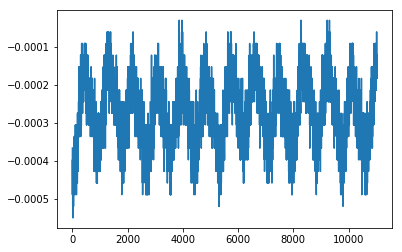

In [10]:
medicion=np.asarray([i[0] for i in myrecording])
plt.plot(medicion)


In [85]:
sd.default.device[1]=3

In [14]:
myarray = np.sin(np.linspace(1,12,11025*10))

In [15]:
sd.play(myarray)

In [35]:
freq,ampl,off=sweepe_placa(genf, 100, 30100, 60,10)
plt.plot(freq,off)

KeyboardInterrupt: 

In [26]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_1/Datos/Respuesta_input_placa_revisado_5k.txt',(freq,ampl,off))

In [31]:
(freq,ampl,off) = np.loadtxt('respuesta_input_placa.out')

Text(0, 0.5, 'Amplitud [u.a.]')

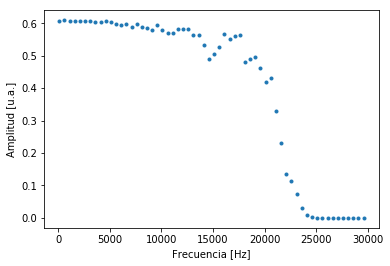

In [25]:
plt.plot(freq,ampl,'.')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [u.a.]')

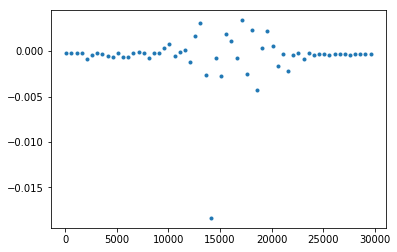

In [17]:
plt.plot(freq,off,'.')

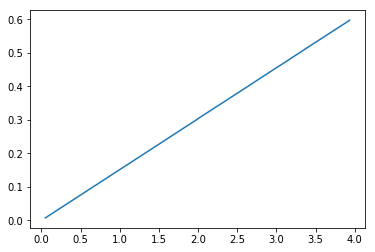

In [40]:
freq,ampl,off=sweepe_placa_ampl(genf, 0.05, 4, 60,10)
plt.plot(freq,ampl)

In [41]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_1/Datos/Caracteriz_ampl_input_placa_revisado_5k_0_4V.txt',(freq,ampl,off))